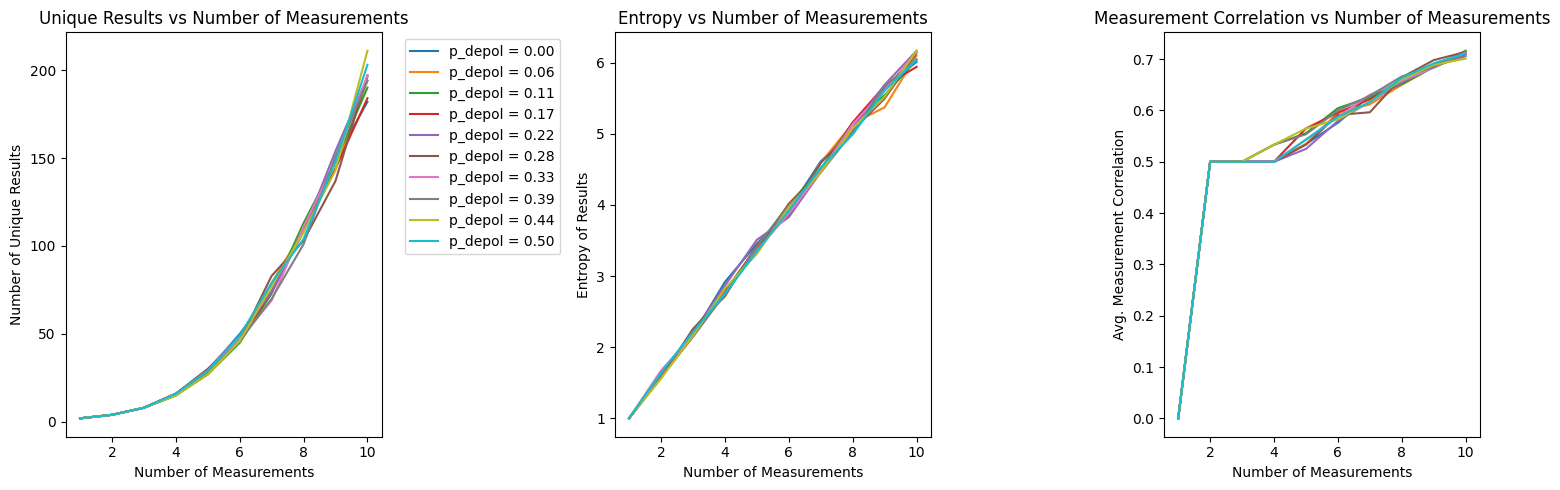

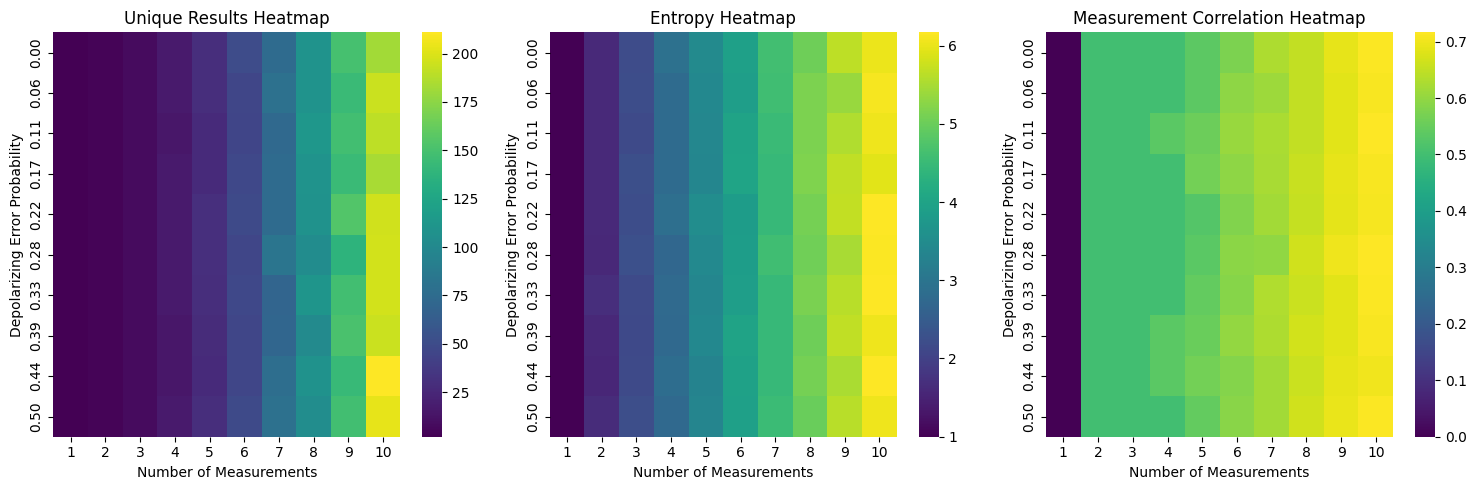

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from qiskit import QuantumCircuit, Aer, execute
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import depolarizing_error, thermal_relaxation_error
from scipy.stats import sem

def create_realistic_noise_model(p_depol, T1, T2):
    """Create a more realistic noise model with depolarizing and thermal relaxation errors."""
    noise_model = NoiseModel()
    dep_error = depolarizing_error(p_depol, 1)
    therm_error = thermal_relaxation_error(T1, T2, p_depol)
    noise_model.add_all_qubit_quantum_error(dep_error, ['u1', 'u2', 'u3'])
    noise_model.add_all_qubit_quantum_error(therm_error, ['u1', 'u2', 'u3'])
    return noise_model

def multi_measurement_circuit(num_measurements):
    """Create a circuit with multiple measurements."""
    qc = QuantumCircuit(1, num_measurements)
    qc.h(0)  # Put qubit in superposition
    for i in range(num_measurements):
        qc.measure(0, i)
        qc.ry(np.pi/4, 0)  # Apply a rotation after each measurement
    return qc

def run_experiment(num_measurements, num_shots, p_depol, T1, T2):
    """Run the experiment and return results."""
    qc = multi_measurement_circuit(num_measurements)
    noise_model = create_realistic_noise_model(p_depol, T1, T2)
    backend = Aer.get_backend('qasm_simulator')
    job = execute(qc, backend, shots=num_shots, noise_model=noise_model)
    result = job.result().get_counts()
    return result

def analyze_results(result, num_measurements):
    """Analyze the results of the experiment."""
    total_shots = sum(result.values())
    unique_results = len(result)
    entropy = sum(-count/total_shots * np.log2(count/total_shots) for count in result.values())
    
    # Calculate measurement correlation
    bitstrings = list(result.keys())
    correlations = []
    for i in range(num_measurements - 1):
        corr = sum(int(bs[i]) == int(bs[i+1]) for bs in bitstrings) / len(bitstrings)
        correlations.append(corr)
    avg_correlation = np.mean(correlations) if correlations else 0
    
    return unique_results, entropy, avg_correlation

# Experiment parameters
num_shots = 1000
p_depol_range = np.linspace(0, 0.5, 10)
max_measurements = 10
T1, T2 = 50, 30  # Relaxation and dephasing times (in arbitrary units)

results = []
for p_depol in p_depol_range:
    experiment_results = []
    for num_measurements in range(1, max_measurements + 1):
        result = run_experiment(num_measurements, num_shots, p_depol, T1, T2)
        unique_results, entropy, correlation = analyze_results(result, num_measurements)
        experiment_results.append((unique_results, entropy, correlation))
    results.append(experiment_results)

# Plotting
plt.figure(figsize=(15, 5))
plt.subplot(131)
for i, p_depol in enumerate(p_depol_range):
    unique_results = [r[0] for r in results[i]]
    plt.plot(range(1, max_measurements + 1), unique_results, label=f'p_depol = {p_depol:.2f}')
plt.xlabel('Number of Measurements')
plt.ylabel('Number of Unique Results')
plt.title('Unique Results vs Number of Measurements')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.subplot(132)
for i, p_depol in enumerate(p_depol_range):
    entropies = [r[1] for r in results[i]]
    plt.plot(range(1, max_measurements + 1), entropies, label=f'p_depol = {p_depol:.2f}')
plt.xlabel('Number of Measurements')
plt.ylabel('Entropy of Results')
plt.title('Entropy vs Number of Measurements')

plt.subplot(133)
for i, p_depol in enumerate(p_depol_range):
    correlations = [r[2] for r in results[i]]
    plt.plot(range(1, max_measurements + 1), correlations, label=f'p_depol = {p_depol:.2f}')
plt.xlabel('Number of Measurements')
plt.ylabel('Avg. Measurement Correlation')
plt.title('Measurement Correlation vs Number of Measurements')

plt.tight_layout()
plt.show()

# Heatmap visualization
plt.figure(figsize=(15, 5))

plt.subplot(131)
heatmap_data = np.array([[r[0] for r in result] for result in results])
sns.heatmap(heatmap_data, cmap='viridis', xticklabels=range(1, max_measurements + 1), yticklabels=[f'{p:.2f}' for p in p_depol_range])
plt.xlabel('Number of Measurements')
plt.ylabel('Depolarizing Error Probability')
plt.title('Unique Results Heatmap')

plt.subplot(132)
heatmap_data = np.array([[r[1] for r in result] for result in results])
sns.heatmap(heatmap_data, cmap='viridis', xticklabels=range(1, max_measurements + 1), yticklabels=[f'{p:.2f}' for p in p_depol_range])
plt.xlabel('Number of Measurements')
plt.ylabel('Depolarizing Error Probability')
plt.title('Entropy Heatmap')

plt.subplot(133)
heatmap_data = np.array([[r[2] for r in result] for result in results])
sns.heatmap(heatmap_data, cmap='viridis', xticklabels=range(1, max_measurements + 1), yticklabels=[f'{p:.2f}' for p in p_depol_range])
plt.xlabel('Number of Measurements')
plt.ylabel('Depolarizing Error Probability')
plt.title('Measurement Correlation Heatmap')

plt.tight_layout()
plt.show()

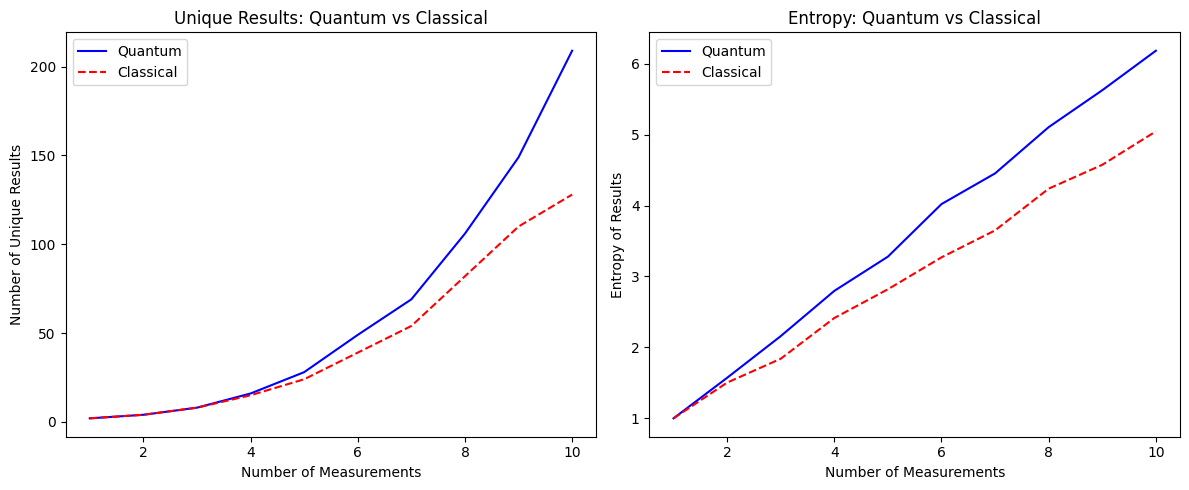

Efficiency gain in unique results (%): 
0.00, 0.00, 0.00, 6.67, 16.67, 25.64, 27.78, 29.27, 35.45, 63.28

Efficiency gain in entropy (%): 
-0.02, 4.53, 17.33, 15.84, 16.32, 22.98, 22.01, 20.47, 22.98, 22.54


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, Aer, execute
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import depolarizing_error, thermal_relaxation_error

def create_noise_model(p_depol, T1, T2):
    noise_model = NoiseModel()
    dep_error = depolarizing_error(p_depol, 1)
    therm_error = thermal_relaxation_error(T1, T2, p_depol)
    noise_model.add_all_qubit_quantum_error(dep_error, ['u1', 'u2', 'u3'])
    noise_model.add_all_qubit_quantum_error(therm_error, ['u1', 'u2', 'u3'])
    return noise_model

def quantum_circuit(num_measurements, rotation_angle):
    qc = QuantumCircuit(1, num_measurements)
    qc.h(0)  # Put qubit in superposition
    for i in range(num_measurements):
        qc.measure(0, i)
        qc.ry(rotation_angle, 0)  # Apply rotation after measurement
    return qc

def run_quantum_experiment(num_measurements, num_shots, p_depol, T1, T2, rotation_angle):
    qc = quantum_circuit(num_measurements, rotation_angle)
    noise_model = create_noise_model(p_depol, T1, T2)
    backend = Aer.get_backend('qasm_simulator')
    job = execute(qc, backend, shots=num_shots, noise_model=noise_model)
    result = job.result().get_counts()
    return result

def classical_simulation(num_measurements, num_shots, p_error):
    results = []
    for _ in range(num_shots):
        measurement = np.random.choice([0, 1])  # Initial random bit
        sequence = [measurement]
        for _ in range(1, num_measurements):
            if np.random.random() < p_error:
                measurement = 1 - measurement  # Flip the bit with probability p_error
            sequence.append(measurement)
        results.append(''.join(map(str, sequence)))
    return {result: results.count(result) for result in set(results)}

def analyze_results(result, num_measurements):
    total_shots = sum(result.values())
    unique_results = len(result)
    entropy = sum(-count/total_shots * np.log2(count/total_shots) for count in result.values())
    return unique_results, entropy

def compare_quantum_classical(max_measurements, num_shots, p_depol, T1, T2, rotation_angle):
    quantum_unique = []
    quantum_entropy = []
    classical_unique = []
    classical_entropy = []

    for num_measurements in range(1, max_measurements + 1):
        # Quantum experiment
        q_result = run_quantum_experiment(num_measurements, num_shots, p_depol, T1, T2, rotation_angle)
        q_unique, q_entropy = analyze_results(q_result, num_measurements)
        quantum_unique.append(q_unique)
        quantum_entropy.append(q_entropy)

        # Classical simulation
        c_result = classical_simulation(num_measurements, num_shots, p_depol)
        c_unique, c_entropy = analyze_results(c_result, num_measurements)
        classical_unique.append(c_unique)
        classical_entropy.append(c_entropy)

    return quantum_unique, quantum_entropy, classical_unique, classical_entropy

# Experiment parameters
max_measurements = 10
num_shots = 1000
p_depol = 0.1
T1, T2 = 50, 30  # Relaxation and dephasing times (in arbitrary units)
rotation_angle = np.pi/4

# Run comparison
q_unique, q_entropy, c_unique, c_entropy = compare_quantum_classical(
    max_measurements, num_shots, p_depol, T1, T2, rotation_angle)

# Plotting
plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.plot(range(1, max_measurements + 1), q_unique, 'b-', label='Quantum')
plt.plot(range(1, max_measurements + 1), c_unique, 'r--', label='Classical')
plt.xlabel('Number of Measurements')
plt.ylabel('Number of Unique Results')
plt.title('Unique Results: Quantum vs Classical')
plt.legend()

plt.subplot(122)
plt.plot(range(1, max_measurements + 1), q_entropy, 'b-', label='Quantum')
plt.plot(range(1, max_measurements + 1), c_entropy, 'r--', label='Classical')
plt.xlabel('Number of Measurements')
plt.ylabel('Entropy of Results')
plt.title('Entropy: Quantum vs Classical')
plt.legend()

plt.tight_layout()
plt.show()

# Calculate and print efficiency gain
unique_gain = [(q - c) / c * 100 for q, c in zip(q_unique, c_unique)]
entropy_gain = [(q - c) / c * 100 for q, c in zip(q_entropy, c_entropy)]

print("Efficiency gain in unique results (%): ")
print(", ".join(f"{gain:.2f}" for gain in unique_gain))

print("\nEfficiency gain in entropy (%): ")
print(", ".join(f"{gain:.2f}" for gain in entropy_gain))